In [1]:
import Main
from Analyser2 import *

In [2]:
modelName = 'Young_Shrub'

In [3]:
# Some PyABC magic to get our set of parameters
from pyabc import (ABCSMC, Distribution, RV, MultivariateNormalTransition)
import scipy as sp
import scipy.stats as st
import tempfile
import os
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
def model(params):
    return Main.generate_and_analyse(modelName, params)

In [5]:
metrics = {  'section_1_slash':(10, 100),
             'section_1_slashr':(10, 100),
             'section_1_plus':(0, 180),
             'section_1_plusr':(0, 180),
             'section_1_decay':(0, 1),
             'section_1_w':(0.1, 2),
             'rule_1_0':(0,1),
             'rule_1_1':(0,1)
          }

In [6]:
prior = Distribution(section_1_slash     =RV("uniform", 10, 100),
                     section_1_slashr    =RV("uniform", 10, 100),
                     section_1_plus      =RV("uniform", 0, 180),
                     section_1_plusr      =RV("uniform", 0, 180),
                     section_1_decay     =RV("uniform", 0, 1),
                     section_1_w         =RV("uniform", 0.1, 2),
                     rule_1_0            =RV("uniform", 0.5,1),
                     rule_1_1            =RV("uniform", 0.5,1)
                    )

In [7]:
abc = ABCSMC(model, prior, distance)

In [8]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "test.db"))

In [9]:
def gen_av_target(n):
    target = model({})
    for i in range(n):
        print(i)
        new_metrics = model({})
        for (k,v) in new_metrics.items():
            if k[-3:] == 'xyz':
                x,y,z = target[k]
                x += new_metrics[k][0]
                y += new_metrics[k][1]
                z += new_metrics[k][2]
                target[k] = (x,y,z)
            else:
                target[k] += new_metrics[k]

    for (k,v) in target.items():
        if k[-3:] == 'xyz':
            x,y,z = target[k]
            target[k] = (x/n, y/n, z/n)
        else:
            target[k] /= n
            
    return target

In [10]:
target = gen_av_target(200)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [11]:
target

{'parentAngle_mean': 45.25030461159386,
 'parentAngle_variance': 17.3306632217786,
 'length_mean': 2.235797878430423,
 'length_variance': 1.0923507790191374,
 'verticalOrientation_mean': 70.26120353488409,
 'verticalOrientation_variance': 35.25028729984424,
 'horizontalOrientation_mean': 177.21656153133097,
 'horizontalOrientation_variance': 103.94485760334317,
 'q1_xyz': (21.255722280096837, 14.466412709822055, 24.685038281622155),
 'q2_xyz': (32.57421056634158, 12.812538600982073, 37.72405261870258),
 'q3_xyz': (26.461101611523805, 14.368474172255757, 31.083011863154262),
 'xyz': (34.949208911136445, 42.2128602566031, 40.01783980792549),
 'trunk_length': 10.22988966199955,
 'totalBiomass': 171.6652496316574}

In [12]:
abc.new(db_path, target)

INFO:History:Start <ABCSMC(id=100, start_time=2019-04-17 23:33:29.969928, end_time=None)>
INFO:Epsilon:initial epsilon is 15.798927729582667


100

In [13]:
history = abc.run(minimum_epsilon=0.5, max_nr_populations=15)

INFO:ABC:t:0 eps:15.798927729582667
INFO:ABC:t:1 eps:11.116543122577173
INFO:ABC:t:2 eps:8.770673978803563
INFO:ABC:t:3 eps:7.652647802271569
INFO:ABC:t:4 eps:6.60587692493073
INFO:ABC:t:5 eps:5.734540100032022
INFO:ABC:t:6 eps:5.351508409869773
INFO:ABC:t:7 eps:4.910130280592706
INFO:ABC:t:8 eps:4.07141052529874
INFO:ABC:t:9 eps:3.6835350485474088
INFO:ABC:t:10 eps:3.054416892329201
INFO:ABC:t:11 eps:2.7780443230351772
INFO:ABC:t:12 eps:2.631462458516821
INFO:ABC:t:13 eps:2.566715866564732
INFO:ABC:t:14 eps:2.3600801941858665
INFO:History:Done <ABCSMC(id=100, start_time=2019-04-17 23:33:29.969928, end_time=2019-04-18 00:05:02.585726)>


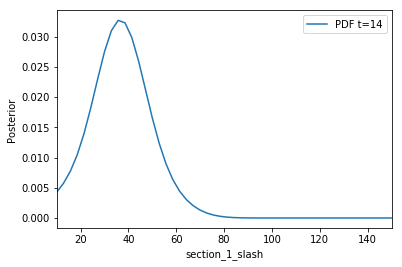

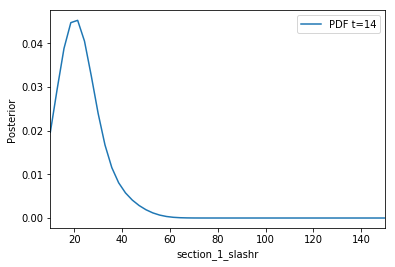

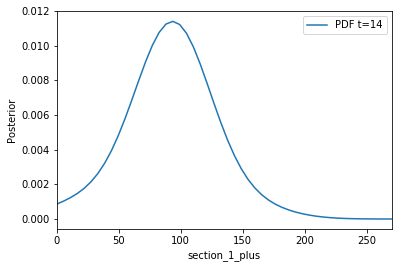

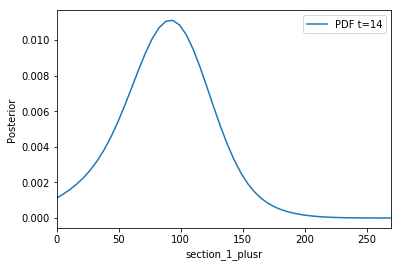

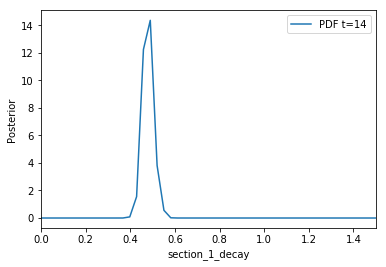

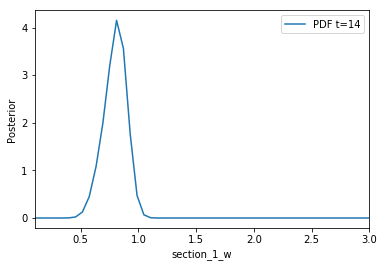

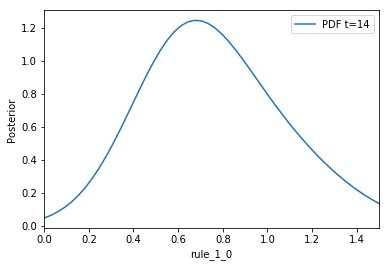

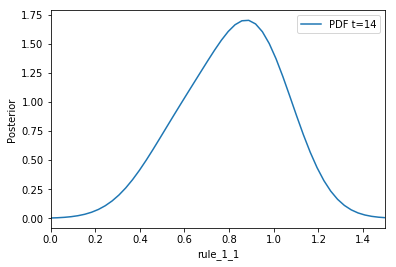

In [15]:
# Visualise results
from pyabc.visualization import plot_kde_1d
for (k,v) in metrics.items():
    fig, ax = plt.subplots()
    for t in range(history.max_t, history.max_t+1):
        df, w = history.get_distribution(m=0, t=t)
        plot_kde_1d(df, w,
                    xmin=v[0], xmax=1.5*v[1],
                    x=k, ax=ax,
                    label="PDF t={}".format(t))
    ax.legend();
    fig.savefig('../../../../Report/images/ys_final/'+k+'_kde')